# Wine Spectator Review Exploration
The workbook below uses roughly 150,000 wine reviews scraped from Wine Spectator in June 2017 and posted to Kaggle https://www.kaggle.com/zynicide/wine-reviews

Using this data I explored a few topics:
1. What was the distribution of points assigned by Wine Spectator overall (80-100 point scale)?
2. Which regions recieve the highest overall point distributions?
3. How do the top regions perform across a variety of wines?
4. Is there a relationship between price and points?
5. Can we use the descriptive text to find logical groupings of wines?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

grid_style = {
    'axes.edgecolor': '#CCCCCC'
}

## Import Data
Load the data, but create a new column which is the Region_1, Province (eg. "Napa Valley, California"). Sometimes Region_1 doesn't have a value. For these records we just will load them as "Province, Other"

In [2]:
def get_data():
    df = pd.DataFrame.from_csv('winemag-data_first150k.csv')
    df['regprov'] = df.apply(lambda x: '{}, {}'.format(x.region_1 if x.region_1 is not np.nan else 'Other', x.province), axis=1)
    return df

reviews = get_data()
reviews.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery,regprov
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,"Napa Valley, California"
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"Toro, Northern Spain"
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"Knights Valley, California"
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"Willamette Valley, Oregon"
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"Bandol, Provence"


## Ratings Distribution
The first two charts show the distributions of points. Only wines scoring over 80 are in the data set. No wine recieved a full 100. I was pleasently surprised to find the wines were mostly normally distributed and not stacked towards the upper end.

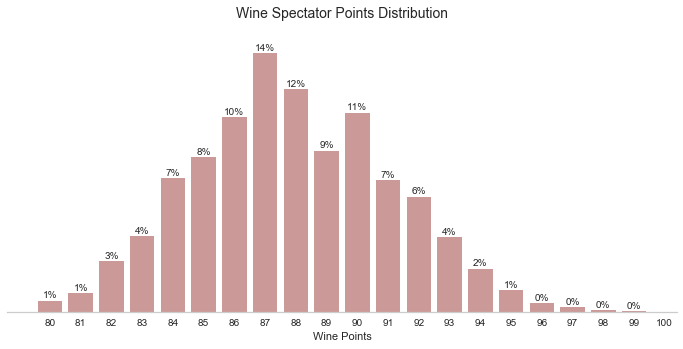

In [96]:
def ratings_distribution(data, cuml):
    %matplotlib inline
    x_val = range(80, 101)
    
    sns.set_style('white', grid_style)
    
    plt.figure(figsize=(12,5))
    heights, _, _ = plt.hist(reviews.points, normed=True, rwidth=0.8, bins=x_val, color='#CC9999', align='left', cumulative=cuml)
    plt.xticks(x_val)
    plt.yticks([])
    plt.xlabel('Wine Points')
    
    if cuml:
        plt.title("Wine Spectator Points Distribution - Cumulative\n", fontsize=14)
    else:
        plt.title("Wine Spectator Points Distribution\n", fontsize=14)

    
    sns.despine(left=True)
    offset = heights.max() * 0.01
    for x in range(80, 100):
        plt.text(x, heights[x-80]+offset, '{:.0%}'.format(heights[x-80]), ha='center')
           
ratings_distribution(reviews, False)

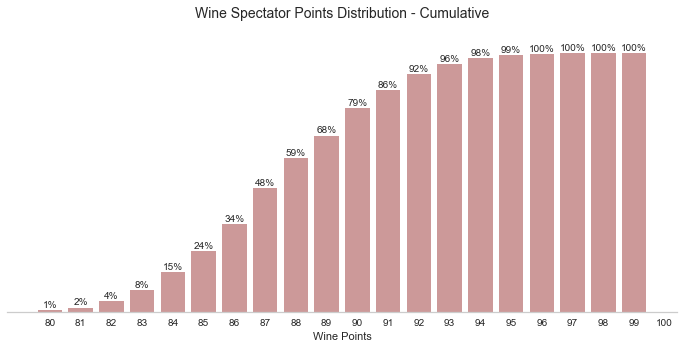

In [97]:
ratings_distribution(reviews, True)

## Showing Top Wine Regions
The following chart pulls together the top regions based on the # of total reviews. These are grouped, and an individual histogram is created for each region/province. Some additional code included is used to produce the desired visuals.

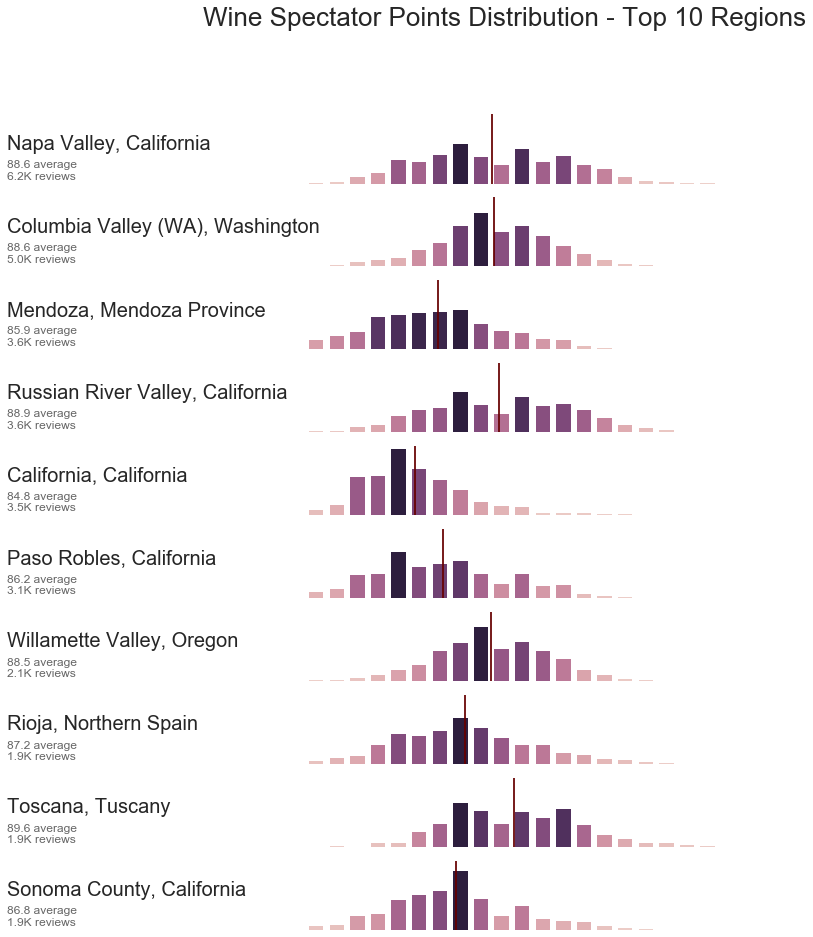

In [134]:
def get_top_entities(data, top_n, groupby):
    return data[groupby].value_counts().head(top_n).index
        
def plot_by_group_alt(data, groupby, top_n):
    top = get_top_entities(data, top_n, groupby)
    df = data[data[groupby].isin(top)]
    
    x_val = range(80, 101)
    fig, axarr = plt.subplots(top_n, 1, figsize=(8, top_n*1.5), sharey=True)
    
    i = 0
    means = []
    counts = []
    all_boxes = []
    for idx in top:
        g = data[data[groupby]==idx]
        heights, _, boxes = axarr[i].hist(g['points'], normed=True, rwidth=0.7, 
                                 bins=x_val, color='#CC9999', align='left')
        sns.despine(ax=axarr[i], left=True, bottom=True)
        axarr[i].set_xlabel('')

        axarr[i].set_yticklabels([])
        axarr[i].set_xticks(x_val)
        if i < top_n + 99:
            axarr[i].set_xticklabels([])
            
        mean = g['points'].mean()
        means.append(mean)
    
        count = len(g)
        counts.append(count)
        
        axarr[i].axvline(mean, color='#660000', linestyle='-')
        all_boxes.append(boxes)
        
    
        norm = mpl.colors.Normalize(vmin=0,vmax=heights.max()*1)
        cmap = sns.cubehelix_palette(20, as_cmap=True)
        cm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        [b.set_facecolor(cm.to_rgba(b.get_height())) for b in boxes]

        i+=1
    
    ymax = axarr[len(top)-1].get_ybound()[1]
    i=0

    for idx in top:
        title = axarr[i].text(65, ymax/2, idx, fontsize=20)
        window_bb = axarr[i].get_window_extent()
        window_h = window_bb.y1 - window_bb.y0
        ypp = ymax / window_h
        axarr[i].text(65, ymax/2 - (30 * ypp), 
                      '{M:.1f} average\n{C:.1f}K reviews'.format(M=means[i], C=counts[i]/1000), fontsize=12, 
                     color='#666666')
        i+=1   
        
    plt.suptitle("Wine Spectator Points Distribution - Top {} Regions".format(top_n), fontsize=26)

plot_by_group_alt(reviews, 'regprov', 10)

## Showing Top Regions & Variety
The following heat map takes each of the top regions and pivots them against the top wines. The "top" is defined by most review counts. Each region & variety pair was calculated using the 90th percentile of the ratings received. For each variety, the highest region was shaded dark purple. The 2nd and 3rd place regions were shaded light purple. All regions not in the top 3 for that variety were left gray. White boxes signify no reivews for that combination.

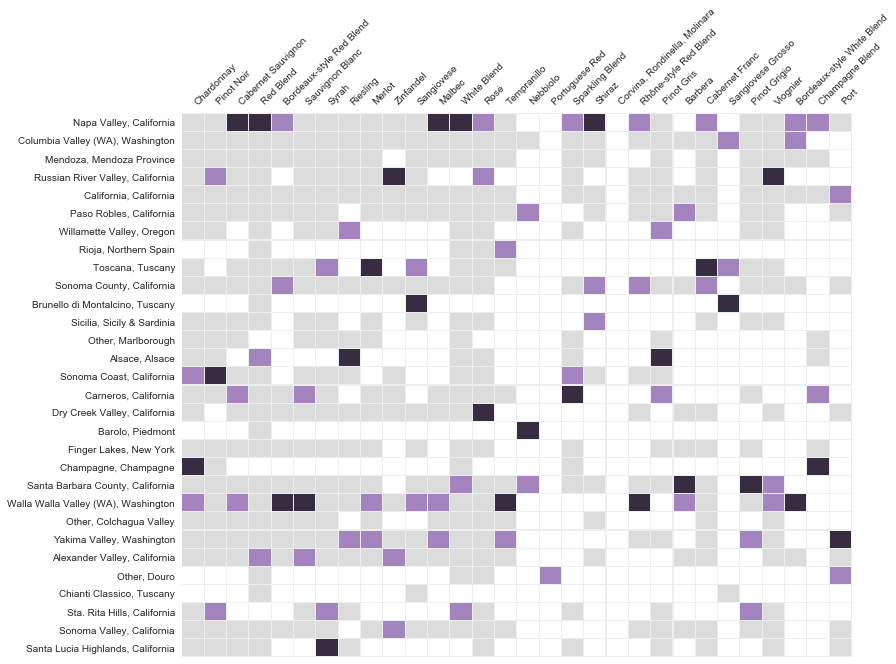

In [107]:
def top_n_row(r):
    idx = r.dropna().index
    a =  r.argsort()
    a = [i for i in a if i>=0]
    max_top = (3 if len(idx)>=3 else len(idx)) * -1
    
    r.loc[idx[a[max_top:]]] = np.arange(max_top*-1)
    r.loc[idx[a[:max_top]]] = -1
    return r

def get_top_two(data, groupby, top_n):
    top_group = data[groupby].value_counts().head(top_n).index
    top_wine = data['variety'].value_counts().head(30).index
    
    d = data[(data[groupby].isin(top_group)) & (data['variety'].isin(top_wine))]
    
    pvt = pd.pivot_table(d, index=groupby, columns='variety', values='points', aggfunc=(lambda x: np.percentile(x, 90)))
    pvt = pvt.loc[top_group, top_wine]
    
    pvt.apply(top_n_row, axis=0)
    return pvt

def plot_top_two(reviews, groupby, top_n):
    p = get_top_two(reviews, 'regprov', 30)
    #https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
    rgb = [
        (220, 220, 220, 255),
        (220, 220, 220, 255),
        (164, 132, 191, 255),
        (164, 132, 191, 255),
        (55, 44, 64, 255)
    ]

    for t in range(0,len(rgb)):
        rgb[t] = [c/255 for c in rgb[t]]

    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', rgb, len(rgb))

    plt.figure(figsize=(12,10))
    ax = sns.heatmap(p, cmap=cmap,
                    linecolor='#EEEEEE',
                    linewidths=0.1,
                     cbar_kws={"boundaries": np.linspace(-1, 4, 4)} ,
                     cbar=False
                    )
    ax.xaxis.tick_top()
    plt.xticks(rotation=45, ha='left')  
    
    #colorbar = ax.collections[0].colorbar
    #colorbar.set_ticks(np.linspace(-.66,.66,3))
    #colorbar.set_ticklabels(['Rest','2nd','1st'])

plot_top_two(reviews, 'regprov', 30)

## Wine Price vs. Ratings
There seems to be some relationship between price and ratings, however any linear model has a really low R^2 value for this. Instead, the following charts show the relationship across all wines (log scale) and sub-$100 wines (linear scale). There is a slight bend as prices increase, but it's nothing massive. If anything, it seems that you can find a 90+ wine at almost any price point, however a higher price just makes that more likely.

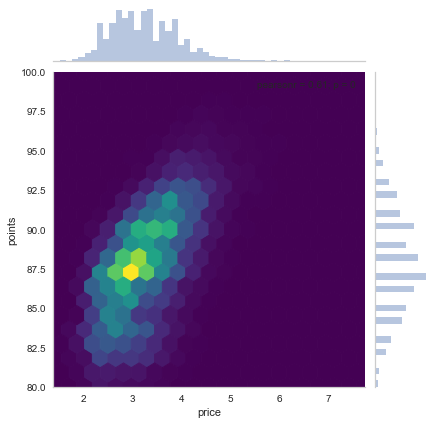

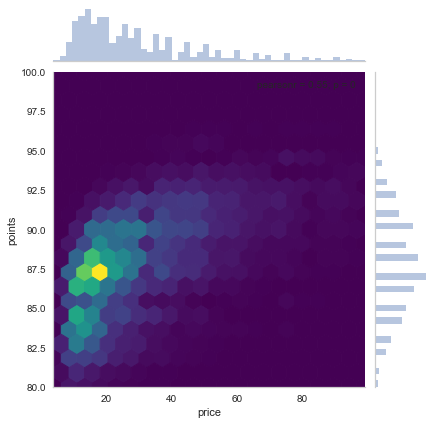

In [126]:
def show_price_points(reviews):
    import math
    d = reviews
    sns.jointplot(d.price.apply(lambda x: math.log(x)), d.points, kind='hex', gridsize=20, cmap='viridis')
    d = reviews[reviews.price<100]
    sns.jointplot(d.price, d.points, kind='hex', gridsize=20, cmap='viridis')
    
show_price_points(reviews)

## Classifying Wines by Description
We perform TFIDF vectorization against the wine descriptions in order to create clusters of wines. When I first ran this, I didn't realize that often the wine variety is repeated within the description. So I modified the stop words to remove the varities as well as some other uninteresting words that popped up. I also didn't care if a word was used once or many times. So the vectorizer uses binary calculations.

After running the TFIDF vectorizer across all 150K reviews, I grouped each wine variety and averaged the scores.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[a-z]+')

def tokenize(s):
    return tokenizer.tokenize(s.lower())

def get_stops(varieties):
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    wines = set([w for v in varieties.unique() for w in tokenize(v)]) | set(['red','white','zin',
                                                                              'flavor','flavors','wine','wines'])
    
    return stops | wines

def get_tfidf_average(reviews, top_n):
    stops = get_stops(reviews['variety'])

    tfidf_m = TfidfVectorizer(tokenizer=tokenize, binary=True, min_df=0.01, 
                              max_df=0.95, stop_words=stops).fit(reviews['description'])
    tfidf_d = tfidf_m.transform(reviews['description'])
    
    df = pd.DataFrame(tfidf_d.toarray()).set_index(reviews['variety'])
    df.columns = tfidf_m.get_feature_names()
    
    top_wines = reviews['variety'].value_counts().head(top_n).index
    
    df_agg = df.loc[top_wines].groupby(level=0).mean()
    
    return df_agg
    
tf_wines = get_tfidf_average(reviews, 60)

## Hierarchical Clustering by Description
Using the dendogram I set a threshold which cut the data into logical groupings. The only outlier was Rose which does not have a threhshold value which would include it without combining another. 

Overall I was very satisified with the results. At a very top level we were able to separate red wines from white wines (with Rose counting as a white). Further down, wines seemed to be grouped into clusters which I would consider pretty accurate. I expected/hoped as much based on the source of the review descriptions. 

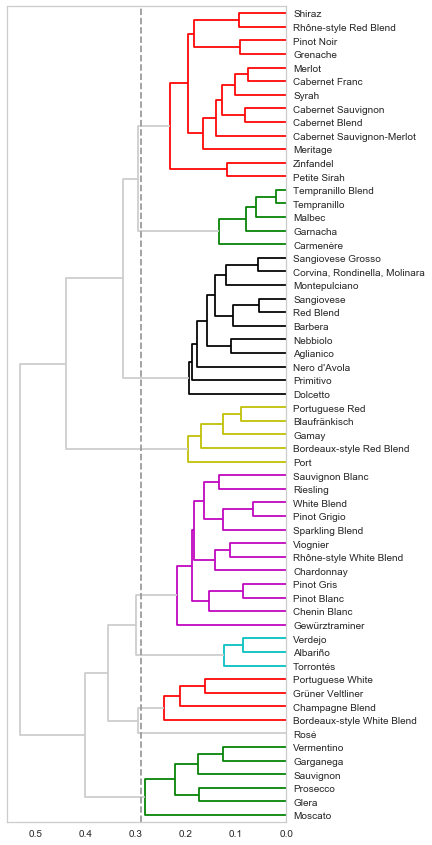

In [90]:
def cluster_wines(tf_matrix, threshold):
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    l = linkage(tf_matrix, method='average', metric='cosine')    
    plt.figure(figsize=(5,15))
    r = dendrogram(l, color_threshold=threshold, labels=tf_matrix.index.values, orientation='left', leaf_font_size=10,
                  above_threshold_color='#CCCCCC')
    
    plt.axvline(threshold, color='#999999', linestyle='--')
    
    clusts = fcluster(l, t=threshold, criterion='distance')
    return clusts
    
wine_clusters = cluster_wines(tf_wines, threshold=.290)

## Descrbing the Clusters
From the data we were able to identify 9 clusters (Rose is by itself) in the dendrogram. Using the cluster lables, and the TFIDF matrix, I selected the top words for each cluster along with 5 random grape varities found in that cluster.

In [129]:
def top_words(tf_matrix, n_words, clusters=None):
    df = tf_matrix.copy()
    
    if clusters is not None:           
        df['cluster'] = clusters
        df = df.set_index('cluster', append=True).groupby(level=1).mean()
        
    for name, grp in df.groupby(level=0):
        order = np.argsort(-grp.values)[0][:n_words]
        
        if clusters is not None:
            print('\n***Cluster - {}***'.format(name))
            df_wines = tf_matrix.index.values[clusters==name]
            max_sel = len(df_wines) if len(df_wines)<5 else 5
            df_wines = np.random.choice(df_wines, max_sel, replace=False)

            print('Varities: ' + ', '.join([c for c in df_wines]))
        else:
            print('\n***Variety - {}***'.format(name))

        print('Top Words: ' + ', '.join([c for c in grp.columns[order]]))
        

        
top_words(tf_wines, 20, clusters=wine_clusters)


***Cluster - 1***
Varities: Sauvignon, Glera, Prosecco, Garganega, Vermentino
Top Words: peach, aromas, fruit, fresh, stone, mineral, honey, citrus, offers, crisp, pair, sweet, creamy, mouth, flower, tones, apricot, notes, almond, bright

***Cluster - 2***
Varities: Portuguese White, Bordeaux-style White Blend, Grüner Veltliner, Champagne Blend
Top Words: acidity, fresh, crisp, ripe, character, rich, texture, green, citrus, pear, fruits, light, fruit, drink, soft, grapefruit, great, fruity, freshness, creamy

***Cluster - 3***
Varities: Rosé
Top Words: acidity, strawberry, crisp, raspberry, fresh, light, dry, fruity, color, ripe, fruits, fruit, drink, bright, berry, finish, touch, soft, caramel, cherry

***Cluster - 4***
Varities: Verdejo, Albariño, Torrontés
Top Words: aromas, palate, finish, citrus, green, nose, peach, lime, tropical, lemon, fresh, drink, clean, feels, good, feel, pineapple, grapefruit, fruit, chunky

***Cluster - 5***
Varities: White Blend, Sparkling Blend, Chenin 